In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Generate Load Time Series

In [8]:
# Simulated time-series (sine wave + noise)
def generate_sine_wave(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = [np.sin(x + np.random.rand()) + 0.1 * np.random.randn(seq_length) for _ in range(num_samples)]
    return np.array(data)

seq_length = 50
num_samples = 1000
real_data = generate_sine_wave(seq_length, num_samples)

# Normalize to range [-1, 1]
real_data = (real_data - real_data.min()) / (real_data.max() - real_data.min())
real_data = 2 * real_data - 1

# Torch tensor
real_data = torch.tensor(real_data, dtype=torch.float32)

# Dataloader
batch_size = 32
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Define Generator and Discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_length):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, seq_length):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


Training Setup

In [10]:
noise_dim = 16
generator = Generator(noise_dim, seq_length).to(device)
discriminator = Discriminator(seq_length).to(device)

loss_fn = nn.BCELoss()
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)


Training Loop

In [11]:
epochs = 200
for epoch in range(epochs):
    for batch in dataloader:
        real_seq = batch[0].to(device)
        batch_size = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_seq = generator(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_real_loss = loss_fn(discriminator(real_seq), real_labels)
        d_fake_loss = loss_fn(discriminator(fake_seq.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_loss = loss_fn(discriminator(fake_seq), real_labels)

        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 20, D Loss: 1.2724, G Loss: 0.8187
Epoch 40, D Loss: 1.3970, G Loss: 0.7076
Epoch 60, D Loss: 1.2878, G Loss: 0.7641
Epoch 80, D Loss: 1.3492, G Loss: 0.7275
Epoch 100, D Loss: 1.4379, G Loss: 0.6451
Epoch 120, D Loss: 1.3873, G Loss: 0.7055
Epoch 140, D Loss: 1.4102, G Loss: 0.6968
Epoch 160, D Loss: 1.3649, G Loss: 0.7034
Epoch 180, D Loss: 1.4566, G Loss: 0.6415
Epoch 200, D Loss: 1.3455, G Loss: 0.7198


Visualize generated data

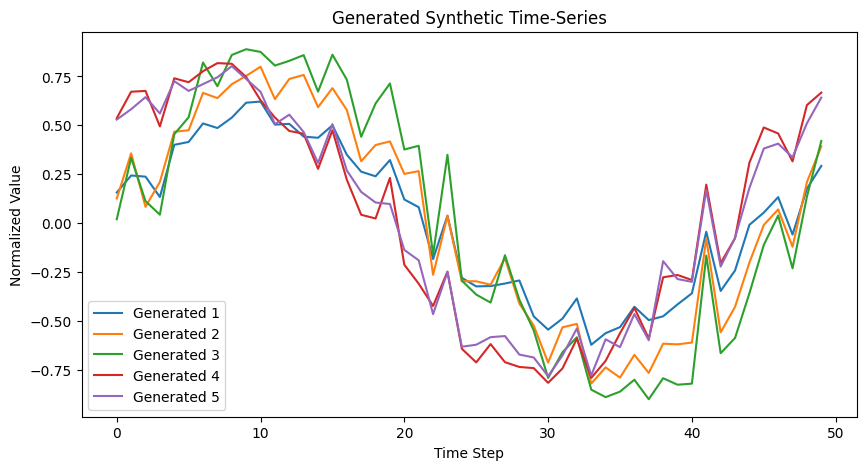

In [12]:
generator.eval()
with torch.no_grad():
    z = torch.randn(5, noise_dim).to(device)
    gen_seq = generator(z).cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(gen_seq[i], label=f"Generated {i+1}")
plt.title("Generated Synthetic Time-Series")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()
